# Equivilent Width

This notebook compares pseudo-equivilent widths (pW) between CMFGEN models and CSP spectroscopy. pW values are determine according to the prescription set forth in the CSP DR1 data release Folatelli et al. 2013. For each feature, "the pW is obtained by defining a straight 'continuum' level between two neighboring flux peaks and computing the integral of the spectrum flux relative to the continuum" (Folatelli 2013).


In [ ]:
import numpy as np
from astropy import units as u
from astropy.table import Table
from matplotlib import pyplot as plt
from sndata.csp import dr1 as data_release
from specutils import SpectralRegion, Spectrum1D
from specutils.analysis import equivalent_width
from specutils.fitting import fit_generic_continuum

data_release.download_module_data()


In [67]:
def get_spectra_for_id(obj_id):
    """Get spectral data for a given data id
    
    Args:
        obj_id (str): The ID of the desired object
        
    Returns:
        A list of observed MJD dates for each spectra
        A 2d list of wavelength values for each date
        A 2d list of flux values for each date
    """
    
    data = data_release.get_data_for_id(obj_id)
    obs_dates = list(set(data['date']))
    
    wavelength, flux = [], []
    for date in obs_dates:
        data_for_date = data[data['date'] == date]
        wavelength.append(data_for_date['wavelength'])
        flux.append(data_for_date['flux'])
        
    return obs_dates, wavelength, flux


def plot_spectra(obs_dates, wavelength, flux, fig=None, axis=None):
    """Plot spectra and their continuums
    
    Args:
        obs_dates  (list): A list of observed MJD dates for each spectra
        wavelength (list): A 2d list of wavelength values for each date
        flux       (list): A 2d list of flux values for each date
    """
    
    if fig is None or axis is None:
        fig, axis = plt.subplots(1, 1, figsize=(10, 10))
        
    plot_data = zip(obs_dates, wavelength, flux)
    
    for date, wave, flux in plot_data:
        axis.plot(wave, flux, label=str(date))
        axis.legend()
    
    return fig, axis  


(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11220fc18>)

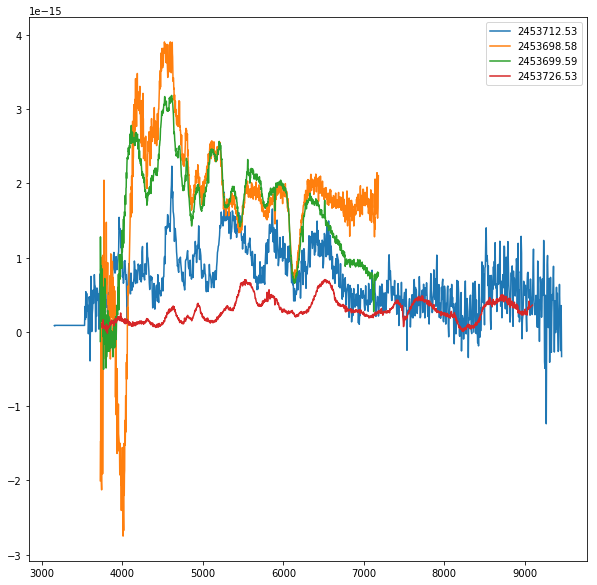

In [7]:
obs_dates, wavelength, flux = get_spectra_for_id('2005kc')
plot_spectra(obs_dates, wavelength, flux)


## Fitting the Continuum

We begin by defining the same set of features considered in Folatelli et al. 2013.

In [8]:
feature_table = Table({
    'feature_name': ['pW1', 'pW2', 'pW3', 'pW4', 'pW5', 'pW6', 'pW7', 'pW8'],
    'feature_id': ['Ca ii H&K', 'Si ii λ4130', 'Mg ii, Fe ii', 'Fe ii, Si ii', 'S ii λ5449, λ5622', 'Si ii λ5972', 'Si ii λ6355', 'Ca ii IR triplet'],
    'lower_blue': [3500, 3900, 3900, 4500, 5150, 5550, 5800, 7500],
    'upper_blue': [3800, 4000, 4150, 4700, 5300, 5700, 6000, 8000],
    'lower_red': [3900, 4000, 4450, 5050, 5500, 5800, 6200, 8200],
    'upper_red': [4100, 4150, 4700, 5550, 5700, 6000, 6600, 8900]
})

feature_table


feature_name,feature_id,lower_blue,upper_blue,lower_red,upper_red
str3,str17,int64,int64,int64,int64
pW1,Ca ii H&K,3500,3800,3900,4100
pW2,Si ii λ4130,3900,4000,4000,4150
pW3,"Mg ii, Fe ii",3900,4150,4450,4700
pW4,"Fe ii, Si ii",4500,4700,5050,5550
pW5,"S ii λ5449, λ5622",5150,5300,5500,5700
pW6,Si ii λ5972,5550,5700,5800,6000
pW7,Si ii λ6355,5800,6000,6200,6600
pW8,Ca ii IR triplet,7500,8000,8200,8900


In [75]:
class UnobservedFeature(Exception):
    pass


def get_peak_coordinates(wavelength, flux, lower_bound, upper_bound):
    """Return coordinates of the maximum flux within given wavelength bounds

    Args:
        wavelength  (array): An array of wavelength values
        flux        (array): An array of flux values
        lower_bound (float): Lower wavelength boundary
        upper_bound (float): Upper wavelength boundary
    
    Returns:
        The wavelength for the maximum flux value
        The maximum flux value
    """
    
    feature_indices = (lower_bound < wavelength) & (wavelength < upper_bound)
    if not any(feature_indices):
        raise UnobservedFeature('Feature not in spectral wavelength range.')
    
    
    feature_flux = flux[feature_indices]
    feature_wavelength = wavelength[feature_indices]
    
    peak_index = np.argmax(feature_flux)
    return feature_wavelength[peak_index], feature_flux[peak_index]


def get_feature_coordinates(wavelength, flux, feature):
    """Get the start and end wavelengths / flux for a given feature
    
    Args:
        wavelength (array): An array of wavelength values
        flux       (array): An array of flux values
        feature      (row): A row from the CSP feature table
    
    Returns:
        A list with the blueward and redward wavelengths
        A list with the blueward and redward flux values
    """

    blue_wave, blue_flux = get_peak_coordinates(
        wavelength, flux, feature['lower_blue'], feature['upper_blue'])
    
    red_wave, red_flux = get_peak_coordinates(
        wavelength, flux, feature['lower_red'], feature['upper_red'])
    
    return [blue_wave, red_wave], [blue_flux, red_flux]


def get_continuum_func(blue_wave, red_wave, blue_flux, red_flux):
    """Fit the pseudo continuum for a given feature
    
    Args:
        feat_wave (list): An list with the start and end wavelength
        feat_flux (list): An array of flux values
    
    Return:
        A linear function fit to the flux peaks bounding a feature
    """
    
    # Fit points to a line
    m = (red_flux - blue_flux) / (red_wave - blue_wave)
    b = blue_flux - m * blue_wave
    return lambda wave: m * np.array(wave) + b

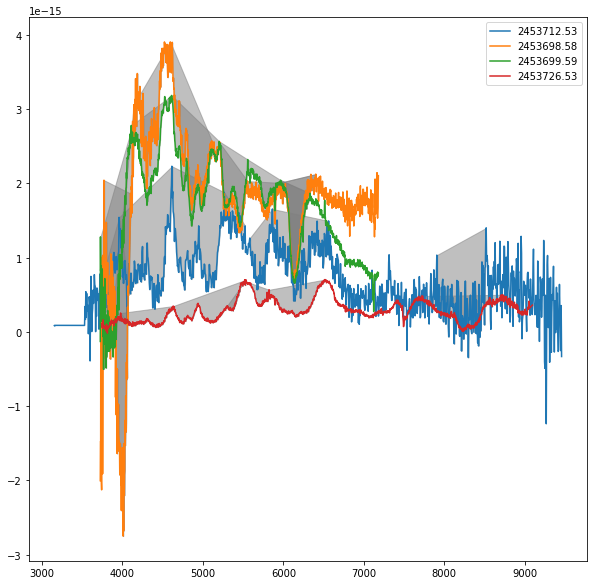

In [76]:
spectral_data = get_spectra_for_id('2005kc')
fig, axis = plot_spectra(*spectral_data)

for obs_dates, wavelength, flux in zip(*spectral_data):
    for feature in feature_table:
        try:
            feat_wave, feat_flux = get_feature_coordinates(wavelength, flux, feature)
        
        except UnobservedFeature:
            pass
        
        
        cont_func = get_continuum_func(*feat_wave, *feat_flux)
        
        indices = (feat_wave[0] < wavelength) & (wavelength < feat_wave[1])
        spectral_wave = wavelength[indices]
        spectral_flux = flux[indices]
        continuum_flux = cont_func(spectral_wave)
        
        axis.fill_between(spectral_wave, spectral_flux, continuum_flux, color='grey', alpha=.5)
            